# Марковский процесс принятия решений

Все методы этой недели созданы для решения Марковских Процессов Принятия Решений. В самом общем смысле МППР определяется тем, как он изменяет состояния и как вычисляются награды.

Переход между состояниями определяется вероятностью $P(s' |s,a)$ - насколько вероятно оказаться в состоянии $s'$ после выполнения действия $a$ из состояния $s$. Существует несколько способов определения наград, но для удобства мы будем использовать функцию $r(s,a,s')$.

_Этот блокнот вдохновлен прекрасным курсом_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _от Беркли_

Для начала давайте определим простой МППР на основе этой картинки:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week02_value_based/mdp.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [2]:
# !pip install gym

In [3]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


We can now use MDP just as any other gym environment:

In [4]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [5]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


# Опционально: Визуализация МППР



Вы также можете визуализировать любой МППР с помощью функции рисования, предоставленной [neer201](https://github.com/neer201).

Вам нужно установить graphviz для системы и для Python.

1. * Для Ubuntu просто выполните: `sudo apt-get install graphviz`
   * Для OSX: `brew install graphviz`
2. `pip install graphviz`
3. Перезапустите блокнот

__Примечание:__ Установка graphviz на некоторых ОС (особенно Windows) может быть сложной. Однако вы можете полностью пропустить эту часть и использовать стандартную визуализацию.

In [6]:
# !pip install graphviz
# from graphviz import Digraph
# import graphviz

In [7]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


In [8]:
# !which dot
# !/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

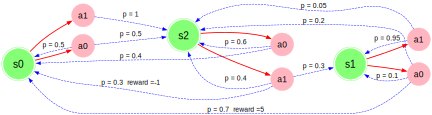

In [9]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

# Value Iteration

<!-- Now let's build something to solve this MDP. The simplest algorithm so far is Value Iteration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

--- -->
<!-- ### Итерация по ценностям (Value Iteration) -->

Теперь давайте построим что-нибудь для решения этого МППР. Самый простой алгоритм на данный момент — Value Iterationм.

Вот псевдокод для Value Iteration:

---

`1.` Инициализировать $V^{(0)}(s)=0$, для всех $s$

`2.` Для $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] \text{,} \quad \forall s = \max_a Q(s,a) \text{,} \quad \forall s$

---

Сначала напишем функцию для вычисления функции ценности действия-состояния $Q^{\pi}$, определяемой следующим образом

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [10]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    q = 0
    for new_state in mdp.get_next_states(state, action):
        p = mdp.get_next_states(state, action)[new_state]
        r = mdp.get_reward(state, action, new_state)
        q += p * (r + gamma * state_values[new_state])
    return q

import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
get_action_value(mdp, test_Vs, 's2', 'a1', 0.9)

0.6900000000000002

In [11]:
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Используя $Q(s,a)$, мы теперь можем определить "следующее" значение V(s) для итерации по ценностям.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [12]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0
    vec_q = []
    for action in mdp.get_possible_actions(state):
        q = get_action_value(mdp, state_values, state, action, gamma)
        vec_q.append(q)
    new_v = max(vec_q)
    return new_v

test_Vs_copy = dict(test_Vs)
get_new_state_value(mdp, test_Vs, 's0', 0.9)

1.8

In [13]:
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

Наконец, давайте объединим всё написанное в работающий алгоритм Value Iteration.

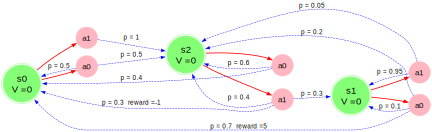

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [14]:
gamma = 0.9           
num_iter = 100
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {}
    for state in mdp.get_all_states():
        new_state_values[state] = get_new_state_value(mdp, state_values, state, gamma)

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

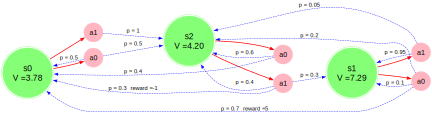

In [15]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [16]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Теперь давайте используем эти $V^{*}(s)$, чтобы найти оптимальные действия для каждого состояния

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
Единственное отличие от $V(s)$ заключается в том, что здесь мы берем не максимум, а argmax: находим действие с максимальным Q(s,a).

In [17]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    max_q = -float("inf")
    optimal_action = -1
    for action in mdp.get_possible_actions(state):
        q = get_action_value(mdp, state_values, state, action, gamma)
        if max_q < q:
            max_q = q
            optimal_action = action
    return optimal_action

In [18]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

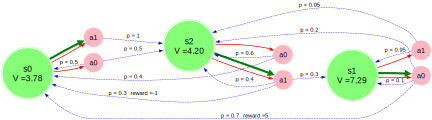

In [19]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [20]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    optimal_action = get_optimal_action(mdp, state_values, s, gamma)
    s, r, done, _ = mdp.step(optimal_action)
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4549


# Frozen lake

In [21]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [22]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {}
        for state in mdp.get_all_states():
            new_state_values[state] = get_new_state_value(mdp, state_values, state, gamma)

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        # print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
            #   (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [ ]:
state_values = value_iteration(mdp)

In [24]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



# Let's visualize!

Обычно интересно посмотреть, что на самом деле изучил ваш алгоритм. Для этого мы построим графики state value функции и оптимальных действий на каждом шаге Value Iteration.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0


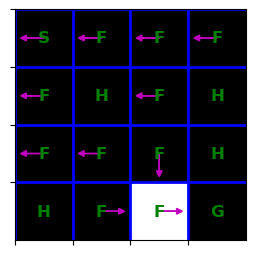

after iteration 1


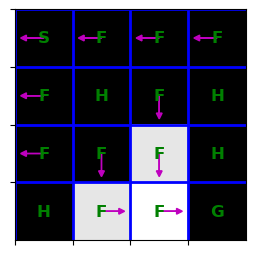

after iteration 2


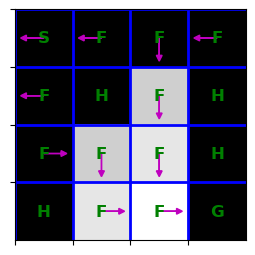

after iteration 3


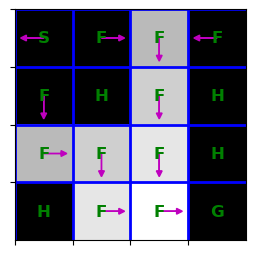

after iteration 4


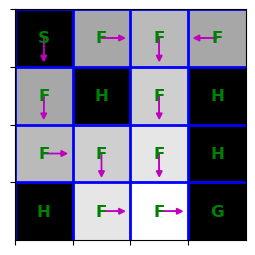

after iteration 5


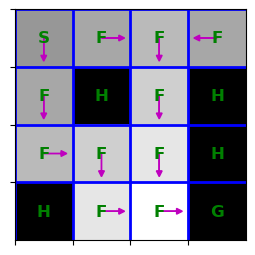

after iteration 6


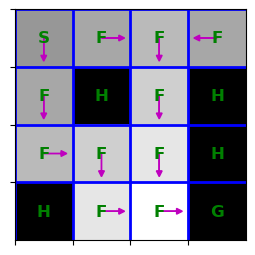

after iteration 7


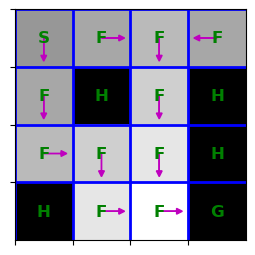

after iteration 8


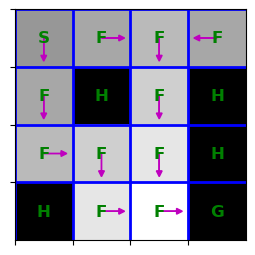

after iteration 9


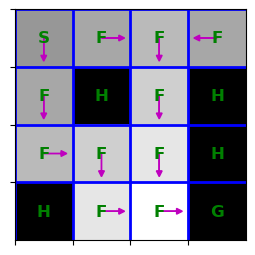

In [26]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29


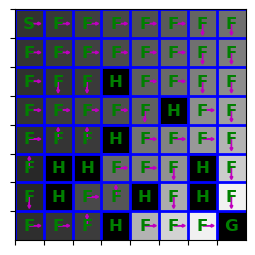

In [27]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [28]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

average reward:  1.0
Well done!


In [29]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

average reward:  0.882
Well done!


In [30]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

average reward:  0.648
Well done!


In [31]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

average reward:  0.725
Well done!


# ДЗ Часть 1: Value iteration convergence

### Найдите МППР, для которого итерация по ценностям сходится долго (1 балл)

Когда мы запустили value iteration на маленькой задаче "frozen lake", последняя итерация, на которой изменялось действие, была итерация 6 - т.е. value iteration вычислила оптимальную политику на итерации 6. Существуют ли гарантии относительно того, сколько итераций потребуется для вычисления оптимальной политики? Таких гарантий нет без дополнительных предположений - мы можем построить МППР таким образом, что жадная политика будет меняться после сколь угодно большого числа итераций.

Ваша задача: определите МППР с не более чем 3 состояниями и 2 действиями, такой что при запуске итерации по ценностям оптимальное действие изменяется на итерации >= 50. Используйте discount=0.95. (Однако заметим, что дисконт здесь не важен - вы можете построить подходящий МППР с любым дисконтом.)

Примечание: value function должна измениться хотя бы один раз после итерации >=50, не обязательно меняться на каждой итерации до >=50.

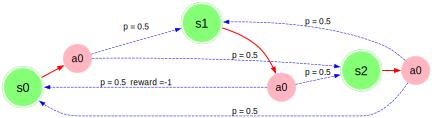

In [32]:
transition_probs = {
    's0': {
        'a0': {'s1': 0.5, 's2': 0.5},
        # 'a1': {'s1': 0.5, 's2': 0.5}
    },
    's1': {
        'a0': {'s0': 0.5, 's2': 0.5},
        # 'a1': {'s0': 0.5, 's2': 0.5}
    },
    's2': {
        'a0': {'s0': 0.5, 's1': 0.5},
        # 'a1': {'s0': 0.5, 's1': 0.5}
    }
}


rewards = {
    # 's0': {
        # 'a0': {'s1': 1},
        # 'a1': {'s1': -1}
    # },
    's1': {
        'a0': {'s0': -1},
        # 'a1': {'s0': 1},
    },
    # 's2': {
        # 'a0': {'s0': 1},
        # 'a1': {'s0': 1},
    # },
}



from mdp import MDP
from numpy import random
mdp = MDP(
    transition_probs, 
    rewards, 
    initial_state=random.choice(tuple(transition_probs.keys()))
)
# Feel free to change the initial_state

if has_graphviz:
    display(plot_graph(mdp))

In [33]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    # print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    optimal_actions = []
    for state in sorted(mdp.get_all_states()):
        optimal_actions.append(get_optimal_action(mdp, state_values, state, gamma))

    new_policy = np.array(optimal_actions)

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions changed = 0 

N actions change

### Доказательсво сходимости Value iteration (1 pts)



**Примечание:** Предполагаем, что $\mathcal{S}, \mathcal{A}$ конечны.

Обновление функции ценности в итерации по ценностям можно переписать в форме оператора Беллмана:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration алгоритм с оператором Беллмана:

---
&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

На [лекции](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) мы установили свойство сжатия оператора Беллмана:


$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

Для всех $V, U$

Используя свойство сжатия оператора Беллмана, теорему Банаха о неподвижной точке и уравнения Беллмана, докажите, что функция ценности сходится к $V^*$ в итерации по ценностям

*<-- Ваше доказательство здесь -->*

### Асинхронная value iteration (2 pts)

Рассмотрим следующий алгоритм:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$    

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---


Заметим, что в отличие от обычной итерации по ценностям, здесь мы обновляем только одно состояние за раз.

**Задание.** Докажите следующее утверждение:

Если для всех $s \in \mathcal{S}$, $s$ встречается в последовательности $(s_0, s_1, ...)$ бесконечно часто, то $V$ сходится к $V*$

*<-- Ваше доказательство здесь -->*


# ДЗ часть 2: Policy iteration

### Policy iteration implementateion (3 pts)

Давайте реализуем точную policy iteration (PI), которая имеет следующий псевдокод:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---
<!-- 
Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation. -->
В отличие от VI, PI должна поддерживать саму политику - выбранные действия для всех состояний - и оценивать $V^{\pi_{n}}$ на основе этой политики. Она изменяет политику только после того, как значения сошлись.

Ниже приведены несколько вспомогательных функций, которые вы можете использовать или не использовать в своей реализации.

In [34]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Давайте напишем функцию `compute_vpi`, которая вычисляет state-value function $V^{\pi}$ для произвольной политики $\pi$.

В отличие от VI, в этот раз нужно найти точное решение, а не выполнять одну итерацию.

Напомним, что $V^{\pi}$ удовлетворяет следующему линейному уравнению:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Вам нужно решить линейную систему в коде. (Найдите точное решение, например, с помощью `np.linalg.solve`.)

In [35]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    all_states = mdp.get_all_states()
    v = {state:0 for state in all_states}
    eps = 1e-6
    iter = 0
    while True:
        
        new_v = {state : 0 for state in all_states}
        for state in all_states:
            action = policy[state]
            transitions = mdp.get_next_states(state, action)
            for new_state in transitions:
                p = transitions[new_state]
                r = mdp.get_reward(state, action, new_state)
                new_v[state] +=  p * (r + gamma * v[new_state])
        
        err = max([abs(v[state] - new_v[state]) for state in all_states])
        v = new_v
        if err < eps:
            break
        # print("iter =", iter, "err =", err)
        iter += 1
    return v

test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': -0.8620411418144959, 's1': -0.2972497733239091, 's2': -0.9578244733128995}


In [36]:

def compute_vpi_matrix_way(mdp, policy, gamma):
    '''
        vpi = B (I - \gamma P)^{-1}
        B = E_a E_s'[r(s, a)]
        P = p(s_j|s_i)
    '''
    dct = {state:index for index, state in enumerate(mdp.get_all_states())}
    n = len(mdp.get_all_states())

    B = np.zeros(n)
    for state in mdp.get_all_states():
        num_state = dct[state]
        action = policy[state]
        B_s = 0.0
        for state_next, p in mdp.get_next_states(state, action).items():
            r = mdp.get_reward(state, action, state_next)
            B_s += p * r
        B[num_state] = B_s
    
    P = np.zeros((n, n))
    for state_i in mdp.get_all_states():
        i = dct[state_i]
        action = policy[state_i]
        for state_j, p in mdp.get_next_states(state_i, action).items():
            j = dct[state_j]
            P[i, j] = p
    
    I = np.eye(n)
    vpi = np.linalg.solve(I - gamma * P, B)
    vpi = {state: vpi[dct[state]] for state in mdp.get_all_states()}
    return vpi


test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

new_vpi = compute_vpi_matrix_way(mdp, test_policy, gamma)

print(new_vpi)

# assert type(
#     new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 8.031919916894896, 's1': 11.171970913211831, 's2': 8.924355463216552}


<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
/var/folders/gr/7gqnwz650mj5qm7pd8xwdkw40000gn/T/ipykernel_26226/3814717152.py:2: SyntaxWarning: invalid escape sequence '\g'
  '''


In [37]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

vpi_matrix = compute_vpi_matrix_way(mdp, test_policy, gamma)
vpi_iter = compute_vpi(mdp, test_policy, gamma)

for s in mdp.get_all_states():
    print(s, vpi_matrix[s], vpi_iter[s], abs(vpi_matrix[s]-vpi_iter[s]))

s0 -0.8620499834856328 -0.8620411418144959 8.841671136905482e-06
s1 -0.29725861499504586 -0.2972497733239091 8.841671136738949e-06
s2 -0.9578333149840365 -0.9578244733128995 8.841671136905482e-06


Как только мы получили новые значения состояний, пора обновить нашу политику.

In [38]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    pi = {}
    for state in mdp.get_all_states():
        optimal_action = get_optimal_action(mdp, vpi, state, gamma)
        pi[state] = optimal_action
    return pi


In [39]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [47]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    # <YOUR CODE: a whole lot of it>
    if policy is None:
        policy = {s: mdp.get_possible_actions(s)[0] for s in mdp.get_all_states()}

    for iteration in range(num_iter):

        # 1. Policy Evaluation
        state_values = compute_vpi(mdp, policy, gamma)

        # 2. Policy Improvement
        new_policy = compute_new_policy(mdp, state_values, gamma)

        # 3. Check if policy changed
        if new_policy == policy:
            # print(f"Policy converged after {iteration} iterations")
            return state_values, policy

        policy = new_policy

    return state_values, policy

__Your PI Results__

In [49]:
state_values = value_iteration(mdp)
pi_VI = { s : get_optimal_action(mdp, state_values, s, gamma) for s in mdp.get_all_states()}
print(pi_VI)

pi_PI = policy_iteration(mdp, test_policy)[1]
print(pi_PI)

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}
{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


## Policy iteration convergence (3 pts)

## Сходимость PI (3 балла)

**Примечание:** Предполагаем, что $\mathcal{S}, \mathcal{A}$ конечны.

Мы можем определить другой оператор Беллмана:

$$(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right]$$

И переписать алгоритм итерации политики в операторной форме:

---

Инициализировать $\pi_0$

**для** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Решить $V_k = T_{\pi_k}V_k$   

&nbsp;&nbsp;&nbsp;&nbsp; Выбрать $\pi_{k+1}$ такую, что $T_{\pi_{k+1}}V_k = TV_k$ 

**конец цикла**

---

Для доказательства сходимости алгоритма нужно доказать два свойства: сжатие и монотонность.

#### Монотонность (0.5 балла)

Для всех $V, U$ если $V(s) \le U(s)$   $\forall s \in \mathcal{S}$ тогда $(T_\pi V)(s) \le (T_\pi U)(s)$   $\forall s \in  \mathcal{S}$

*<-- Ваше доказательство здесь -->*

#### Сжатие (1 балл)

$$
||T_\pi V - T_\pi U||_{\infty} \le \gamma ||V - U||_{\infty}
$$

Для всех $V, U$

*<-- Ваше доказательство здесь -->*

#### Сходимость (1.5 балла)

Докажите, что существует итерация $k_0$ такая, что $\pi_k = \pi^*$ для всех $k \ge k_0$

*<-- Ваше доказательство здесь -->*


<!-- **Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.
We can define another Bellman operator:

$$(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right]$$

And rewrite policy iteration algorithm in operator form:


---

Initialize $\pi_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Solve $V_k = T_{\pi_k}V_k$    -->

<!-- &nbsp;&nbsp;&nbsp;&nbsp; Select $\pi_{k+1}$ s.t. $T_{\pi_{k+1}}V_k = TV_k$ 

**end for**

---

To prove convergence of the algorithm we need to prove two properties: contraction an monotonicity.

#### Monotonicity (0.5 pts)

For all $V, U$ if $V(s) \le U(s)$   $\forall s \in \mathcal{S}$ then $(T_\pi V)(s) \le (T_\pi U)(s)$   $\forall s \in  \mathcal{S}$

*<-- Your proof here -->* -->

<!-- #### Contraction (1 pts)

$$
||T_\pi V - T_\pi U||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

*<-- Your proof here -->*

<!-- #### Convergence (1.5 pts)

Prove that there exists iteration $k_0$ such that $\pi_k = \pi^*$ for all $k \ge k_0$

*<-- Your proof here -->* --> -->